In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [2]:
plot_samples = False

scene_selection = 1
res_mult = 1

scenes = ['car', 'chess', 'dragon', 'sponza']
scene_distances = np.array([[300.0, 600.0,  2000.0],
                            [230.0, 300.0,   700.0],
                            [300.0, 500.0,   700.0],
                            [500.0, 1000.0, 5000.0]], dtype=np.float32)

scene = scenes[scene_selection-1]
focus_distances = scene_distances[scene_selection-1]
n_f = len(focus_distances)

In [3]:
# Retina plane
z_r = 1.0
n_r = 1024
size_r = 2.0
pitch_r = size_r / n_r

# Field of view
fov_factor = size_r / z_r
fov = 2 * np.arctan(fov_factor / 2) * 180/np.pi

# Pupil plane
z_p = 0.0
size_p = 8.0

In [4]:
# Plane U
z_u = 0.0
n_u = 3
size_u = 10.0
pitch_u = size_u / n_u

# Plane V
z_v = 265.0
n_v = 8
size_v = 540.0/4
pitch_v = size_v / n_v

# View chunks.
chunk_v = 1
n_chunk = n_v//chunk_v

print('[Sampled Light Field]')
print('Plane U:    {:4} × {:4.2f} mm = {:5} mm    z_u = {:5} mm'.format(n_u, pitch_u, size_u, z_u))
print('Plane V:    {:4} × {:4.2f} mm = {:5} mm    z_v = {:5} mm'.format(n_v, pitch_v, size_v, z_v))
print('          ({:2}×{:2})'.format(n_chunk, chunk_v))

print('\n[Retina Estimate with FoV = {:4.1f}°]'.format(fov))
print('Focus at U: {:7.2f}'.format(fov_factor * z_u / pitch_u))
print('Focus at V: {:7.2f}'.format(fov_factor * z_v / pitch_v))
print('Focus at ∞: {:7.2f}'.format(fov_factor * abs(z_u - z_v) / max(pitch_u, pitch_v)))

print('\nNumber of rays: {:,}'.format((n_u * n_v)**2))

[Sampled Light Field]
Plane U:       3 × 3.33 mm =  10.0 mm    z_u =   0.0 mm
Plane V:       8 × 16.88 mm = 135.0 mm    z_v = 265.0 mm
          ( 8× 1)

[Retina Estimate with FoV = 90.0°]
Focus at U:    0.00
Focus at V:   31.41
Focus at ∞:   31.41

Number of rays: 576


In [5]:
# Plane A
z_a = 8.0
n_a = 12 * res_mult # 48
size_a = 24.0
pitch_a = size_a / n_a

# Plane B
z_b = 136.0
n_b = 140 * res_mult # 560
size_b = 280.0
pitch_b = size_b / n_b

print('[Display Light Field]')
print('Plane A:    {:4} × {:4.2f} mm = {:5} mm    z_a = {:5} mm'.format(n_a, pitch_a, size_a, z_a))
print('Plane B:    {:4} × {:4.2f} mm = {:5} mm    z_b = {:5} mm'.format(n_b, pitch_b, size_b, z_b))

print('\n[Retina Estimate with FoV = {:4.1f}°]'.format(fov))
print('Focus at A: {:7.2f}'.format(fov_factor * z_a / pitch_a))
print('Focus at B: {:7.2f}'.format(fov_factor * z_b / pitch_b))
print('Focus at ∞: {:7.2f}'.format(fov_factor * abs(z_a - z_b) / max(pitch_a, pitch_b)))

print('\nNumber of elements: {:,}'.format((n_a * n_b)**2))

[Display Light Field]
Plane A:      12 × 2.00 mm =  24.0 mm    z_a =   8.0 mm
Plane B:     140 × 2.00 mm = 280.0 mm    z_b = 136.0 mm

[Retina Estimate with FoV = 90.0°]
Focus at A:    8.00
Focus at B:  136.00
Focus at ∞:  128.00

Number of elements: 2,822,400


In [6]:
def bytesize_string(nbytes):
    unit =          ['B',  'KiB' ,  'MiB' ,  'GiB' ,  'TiB' ,  'PiB' ,  'EiB' ,  'ZiB' ,  'YiB' ]
    size = np.array([ 1 , 1/2**10, 1/2**20, 1/2**30, 1/2**40, 1/2**50, 1/2**60, 1/2**70, 1/2**80]) * nbytes
    order_of_magnitude = np.argmax(size < 1.0) - 1
    return '{} {}'.format(size[order_of_magnitude], unit[order_of_magnitude])

def array_stats(a):
    print('{} × {} = {} | min: {}, max: {}, avg: {}'.format(a.shape, a.dtype, bytesize_string(a.nbytes), np.amin(a), np.amax(a), np.average(a)))
    
def display_image(values, color_map=None):
    values = values if color_map is None else cm.get_cmap(color_map)(values)
    display(Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)))

def save_image(name, values, color_map=None):
    values = values if color_map is None else cm.get_cmap(color_map)(values)
    Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)).save('figures/{}.png'.format(name))

def compute_spectrum(values):
    return fft.fftshift(fft.fft2(np.array(Image.fromarray((values * 255.0).astype(np.uint8)).convert('L'))))

def spectral_log(spectrum):
    return np.log(1.0 + np.abs(spectrum))

def sampling_lattice(n, pitch=1.0):
    return (np.arange(n, dtype=np.float32) - (n - 1)/2) * pitch

def dot(a, b):
    return np.einsum('...i,...i', a, b)

In [7]:
def intersect_plane(x_1, x_2, z_1, z_2, z_out):
    return (z_2 - z_out)/(z_2 - z_1) * x_1 + (z_1 - z_out)/(z_1 - z_2) * x_2

def intersect_retina(x_1, x_2, z_1, z_2, z_r, z_f):
    return z_r * ((z_2/z_f - 1)/(z_2 - z_1) * x_1 + (z_1/z_f - 1)/(z_1 - z_2) * x_2)

def intersect_plane_from_eye(x_p, x_r, z_out, z_f):
    return (1 - z_out/z_f) * x_p + z_out * x_r



def compute_element_size_p(pitch_a, pitch_b, z_a, z_b):
    return np.abs(z_b/(z_b - z_a) * pitch_a) + np.abs(z_a/(z_a - z_b) * pitch_b)

def compute_element_size_r(pitch_a, pitch_b, z_a, z_b, z_f):
    return np.abs((z_b/z_f - 1)/(z_b - z_a) * pitch_a) + np.abs((z_a/z_f - 1)/(z_a - z_b) * pitch_b)



def compute_phi_GPU(x_r, x_a, x_b, pitch_a, pitch_b, size_p, z_a, z_b, z_f):
    # Ratios for projection of plane A and plane B to the pupil plane.
    ratio_a = cp.reciprocal(1.0 - z_a/z_f, dtype=cp.float32)
    ratio_b = cp.reciprocal(1.0 - z_b/z_f, dtype=cp.float32)
    # Project display samples to the pupil plane.
    x_p_from_a = ratio_a * (x_a - z_a * x_r)
    x_p_from_b = ratio_b * (x_b - z_b * x_r)
    # Projection half-sizes.
    proj_size_a = cp.abs(ratio_a * pitch_a)
    proj_size_b = cp.abs(ratio_b * pitch_b)
    # Projection A.
    lower_bound_a = cp.subtract(x_p_from_a, proj_size_a/2, out=x_p_from_a)
    upper_bound_a = cp.add(lower_bound_a, proj_size_a)
    # Projection B.
    lower_bound_b = cp.subtract(x_p_from_b, proj_size_b/2, out=x_p_from_b)
    upper_bound_b = cp.add(lower_bound_b, proj_size_b)
    # Intersect the projections.
    lower_bound = cp.clip(lower_bound_a, lower_bound_b, upper_bound_b, out=lower_bound_a)
    upper_bound = cp.clip(upper_bound_a, lower_bound_b, upper_bound_b, out=upper_bound_a)
    # Intersect with pupil.
    lower_bound = cp.clip(lower_bound, -size_p/2, size_p/2, out=lower_bound)
    upper_bound = cp.clip(upper_bound, -size_p/2, size_p/2, out=upper_bound)
    # Return the intersection length, normalized by the pupil size.
    return cp.divide(cp.subtract(upper_bound, lower_bound, out=upper_bound), size_p, out=upper_bound)

In [8]:
lattice_r = sampling_lattice(n_r, pitch_r)

lattice_a = sampling_lattice(n_a, pitch_a)
lattice_b = sampling_lattice(n_b, pitch_b)

lattice_u = sampling_lattice(n_u, pitch_u)
lattice_v = sampling_lattice(n_v, pitch_v).reshape(n_chunk, chunk_v)

In [9]:
%%time
print('Computing active elements...')

# Display element coordinates on the pupil, retina and sampling planes.
element_coord_p = intersect_plane( lattice_a.reshape(   n_a, 1), lattice_b.reshape(   1, n_b), z_a, z_b, z_p)
element_coord_r = intersect_retina(lattice_a.reshape(1, n_a, 1), lattice_b.reshape(1, 1, n_b), z_a, z_b, z_r, focus_distances.reshape(n_f, 1, 1))
element_coord_u = intersect_plane( lattice_a.reshape(   n_a, 1), lattice_b.reshape(   1, n_b), z_a, z_b, z_u)
element_coord_v = intersect_plane( lattice_a.reshape(   n_a, 1), lattice_b.reshape(   1, n_b), z_a, z_b, z_v)

# Display element projection size on the pupil and retina.
element_size_p = compute_element_size_p(pitch_a, pitch_b, z_a, z_b)
element_size_r = compute_element_size_r(pitch_a, pitch_b, z_a, z_b, focus_distances)

# Display element incidence on the pupil and retina.
element_incidence_on_pupil = np.abs(element_coord_p) <= (size_p + element_size_p)/2
element_incidence_on_retina = np.abs(element_coord_r) <= (size_r + element_size_r.reshape(n_f, 1, 1))/2

# Display element incidence on the eye.
element_incidence_on_eye = np.logical_and(element_incidence_on_pupil, np.any(element_incidence_on_retina, axis=0))

# Active display elements.
element_active_a, element_active_b = np.nonzero(element_incidence_on_eye)
n_ab = len(element_active_a)

# Active display element coordinates.
element_coord_p = element_coord_p[   element_active_a, element_active_b]
element_coord_r = element_coord_r[:, element_active_a, element_active_b]
element_coord_u = element_coord_u[   element_active_a, element_active_b]
element_coord_v = element_coord_v[   element_active_a, element_active_b]
element_coord_a = lattice_a[element_active_a]
element_coord_b = lattice_b[element_active_b]

print('\nActive display elements:', n_ab)

Computing active elements...

Active display elements: 672
Wall time: 969 µs


In [10]:
%%time
print('Computing incidence and counts...')

# Light field sample coodinates on planes A and B.
sample_coord_a = intersect_plane(lattice_u.reshape(n_u, 1, 1), lattice_v.reshape(1, n_chunk, chunk_v), z_u, z_v, z_a)
sample_coord_b = intersect_plane(lattice_u.reshape(n_u, 1, 1), lattice_v.reshape(1, n_chunk, chunk_v), z_u, z_v, z_b)

# Light field sample incidence on display elements.
coord_a = sample_coord_a.reshape(1, n_u, n_chunk, chunk_v) - element_coord_a.reshape(n_ab, 1, 1, 1)
coord_b = sample_coord_b.reshape(1, n_u, n_chunk, chunk_v) - element_coord_b.reshape(n_ab, 1, 1, 1)
sample_incidence_per_element = np.logical_and(np.logical_and(coord_a > -pitch_a/2, coord_a <= pitch_a/2), np.logical_and(coord_b > -pitch_b/2, coord_b <= pitch_b/2))

# Light field sample count per display element.
sample_count_per_element = np.count_nonzero(sample_incidence_per_element, axis=(1, 2, 3)).astype(np.uint16)

print('\nLight field sample incidence and count per display element:')
array_stats(sample_incidence_per_element)
array_stats(sample_count_per_element)



# Light field sample coodinates on the pupil.
sample_coord_p = intersect_plane( lattice_u.reshape(n_u, 1, 1), lattice_v.reshape(1, n_chunk, chunk_v), z_u, z_v, 0.0)

# Light field sample incidence on the pupil.
sample_incidence_on_pupil = np.abs(sample_coord_p) <= size_p/2

# Light field sample coodinates on the retina.
sample_coord_r = intersect_retina(lattice_u.reshape(1, n_u, 1, 1), lattice_v.reshape(1, 1, n_chunk, chunk_v), z_u, z_v, z_r, focus_distances.reshape(n_f, 1, 1, 1))

# Light field sample incidence on retina pixels.
coord_r = sample_coord_r.reshape(n_f, 1, n_u, n_chunk, chunk_v) - lattice_r.reshape(1, n_r, 1, 1, 1)
sample_incidence_per_pixel = np.logical_and(np.logical_and(coord_r > -pitch_r/2, coord_r <= pitch_r/2), sample_incidence_on_pupil)

# Light field sample count per retina pixel.
sample_count_per_pixel = np.count_nonzero(sample_incidence_per_pixel, axis=(2, 3, 4)).astype(np.uint16)

print('\nLight field sample incidence and count per retina pixel:')
array_stats(sample_incidence_per_pixel)
array_stats(sample_count_per_pixel)



# Display element incidence on retina pixels.
element_incidence_per_pixel = np.abs(lattice_r.reshape(1, n_r, 1) - element_coord_r.reshape(n_f, 1, n_ab)) < (pitch_r + element_size_r.reshape(n_f, 1, 1))/2

# Display element count per retina pixel.
element_count_per_pixel = np.count_nonzero(element_incidence_per_pixel, axis=2).astype(np.uint16)

print('\nDisplay element incidence and count per retina pixel:')
array_stats(element_incidence_per_pixel)
array_stats(element_count_per_pixel)

Computing incidence and counts...

Light field sample incidence and count per display element:
(672, 3, 8, 1) × bool = 15.75 KiB | min: False, max: True, avg: 0.001488095238095238
(672,) × uint16 = 1.3125 KiB | min: 0, max: 1, avg: 0.03571428571428571

Light field sample incidence and count per retina pixel:
(3, 1024, 3, 8, 1) × bool = 72.0 KiB | min: False, max: True, avg: 0.0009765625
(3, 1024) × uint16 = 6.0 KiB | min: 0, max: 2, avg: 0.0234375

Display element incidence and count per retina pixel:
(3, 1024, 672) × bool = 1.96875 MiB | min: False, max: True, avg: 0.014291914682539682
(3, 1024) × uint16 = 6.0 KiB | min: 7, max: 13, avg: 9.604166666666666
Wall time: 46.8 ms


In [11]:
%%time
print('Computing light field samples linear interpolation weights...')

weight_u = np.maximum(0.0, 1.0 - np.abs(element_coord_u.reshape(n_ab, 1, 1, 1) - lattice_u.reshape(1, n_u,       1,       1)) / pitch_u)
weight_v = np.maximum(0.0, 1.0 - np.abs(element_coord_v.reshape(n_ab, 1, 1, 1) - lattice_v.reshape(1,   1, n_chunk, chunk_v)) / pitch_v)
interp_linear_map = weight_u * weight_v

Computing light field samples linear interpolation weights...
Wall time: 998 µs


In [12]:
%%time
print('Computing assignments to chunk groups...')

# Light field chunk incidence on display elements.
chunk_incidence_per_element = np.logical_or(np.any(sample_incidence_per_element, axis=(1, 3)), np.any(interp_linear_map, axis=(1, 3)))

# Light field chunk incidence on retina pixels.
chunk_incidence_per_pixel = np.any(sample_incidence_per_pixel, axis=(2, 4))

# Maximum ammount of light field chunks per display element or retina pixel.
chunk_group_element = np.amax(np.count_nonzero(chunk_incidence_per_element, axis=1))
chunk_group_pixel = np.amax(np.count_nonzero(chunk_incidence_per_pixel, axis=2))
chunk_group = max(chunk_group_element, chunk_group_pixel)

# Number of light field groups.
n_group = n_chunk - (chunk_group - 1)

print('\nLight field group size:', chunk_group)
print('Number of light field groups:', n_group)



# Display element assignment to light field groups.
element_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_element, axis=1), n_group-1).reshape(1, n_ab) == np.arange(n_group).reshape(n_group, 1)

# Retina pixel count per light field group.
element_count_per_group = np.count_nonzero(element_assignment_per_group, axis=1).astype(np.uint16)

# Display element indices per light field group.
element_indices_per_group = [np.nonzero(group)[0] for group in element_assignment_per_group]

print('\nDisplay element assignment and count per light field group:')
array_stats(element_assignment_per_group)
array_stats(element_count_per_group)



# Retina pixel assignment to light field groups.
pixel_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_pixel, axis=2), n_group-1).reshape(n_f, 1, n_r) == np.arange(n_group).reshape(1, n_group, 1)

# Retina pixel count per light field group.
pixel_count_per_group = np.count_nonzero(pixel_assignment_per_group, axis=2).astype(np.uint16)

# Retina pixel indices per light field group.
pixel_indices_per_group = [[np.nonzero(group)[0] for group in focus] for focus in pixel_assignment_per_group]

print('\nRetina pixel assignment and count per light field group:')
array_stats(pixel_assignment_per_group)
array_stats(pixel_count_per_group)

Computing assignments to chunk groups...

Light field group size: 2
Number of light field groups: 7

Display element assignment and count per light field group:
(7, 672) × bool = 4.59375 KiB | min: False, max: True, avg: 0.14285714285714285
(7,) × uint16 = 14.0 B | min: 20, max: 523, avg: 96.0

Retina pixel assignment and count per light field group:
(3, 7, 1024) × bool = 21.0 KiB | min: False, max: True, avg: 0.14285714285714285
(3, 7) × uint16 = 42.0 B | min: 2, max: 1006, avg: 146.28571428571428
Wall time: 3.99 ms


In [13]:
%%time
print('Computing φ values...')

phi_values = np.zeros((n_f, n_ab, n_u, n_chunk, chunk_v), dtype=np.float32)

with tqdm(total=n_f * n_ab) as pbar:
    # Load coordinates into the GPU.
    coord_r_GPU = cp.array(sample_coord_r)
    coord_a_GPU = cp.array(element_coord_a)
    coord_b_GPU = cp.array(element_coord_b)

    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # For each display element...
        for element_index in range(n_ab):
            # Compute the phi value for each light field sample.
            phi_GPU = compute_phi_GPU(coord_r_GPU[index_f], coord_a_GPU[element_index], coord_b_GPU[element_index], pitch_a, pitch_b, size_p, z_a, z_b, z_f)
            phi_values[index_f, element_index] = phi_GPU.get()
            # Update progress bar.
            pbar.update()

    # Free GPU memory
    del coord_r_GPU
    del coord_a_GPU
    del coord_b_GPU
    del phi_GPU
    mempool.free_all_blocks()

# Remove samples that do not enter the pupil.
phi_values = phi_values * sample_incidence_on_pupil

print('\nφ values:')
array_stats(phi_values)

Computing φ values...


  0%|          | 0/2016 [00:00<?, ?it/s]


φ values:
(3, 672, 3, 8, 1) × float32 = 189.0 KiB | min: 0.0, max: 0.25684934854507446, avg: 0.0014880952658131719
Wall time: 1.54 s


In [14]:
%%time
print('Computing linear maps...')

reference_linear_map = sample_incidence_per_pixel.astype(np.float32) / np.maximum(sample_count_per_pixel, 1).reshape(n_f, n_r, 1, 1, 1)
naive_linear_map = sample_incidence_per_element.astype(np.float32) / np.maximum(sample_count_per_element, 1).reshape(n_ab, 1, 1, 1)

simulation_linear_map = np.zeros((n_f, n_r, n_ab), dtype=np.float32)
projection_linear_map = np.zeros((n_f, n_ab, n_u, n_chunk, chunk_v), dtype=np.float32)
autocorrelation_linear_map = np.zeros((n_f+1, n_ab, n_ab), dtype=np.float32)

with tqdm(total=n_f * n_r) as pbar:
    # For each focus distance...
    for index_f, z_f in enumerate(focus_distances):
        # For each retina pixel...
        for index_r in range(n_r):
            # Get incident display elements and incident light field samples.
            element_indices = np.nonzero(element_incidence_per_pixel[index_f, index_r])[0]
            sample_indices = np.nonzero(sample_incidence_per_pixel[index_f, index_r])
            # Phi values for incident display elements and incident light field samples.
            incident_phi = phi_values[index_f, element_indices.reshape(-1, 1), sample_indices[0], sample_indices[1], sample_indices[2]]
            # Simulation: For each incident display element, take the average phi value over the incident light field samples.
            simulation_linear_map[index_f, index_r, element_indices] = np.average(incident_phi, axis=1)
            # Projection: Phi values divided by sample count per pixel (times the pixel pitch).
            projection_linear_map[index_f, element_indices.reshape(-1, 1), sample_indices[0], sample_indices[1], sample_indices[2]] += incident_phi / np.maximum(sample_count_per_pixel[index_f, index_r], 1)
            # Autocorrelation: For each pair of incident display elements, accumulate the average of the product of sampled phi values (times the pixel pitch).
            autocorrelation_linear_map[index_f, element_indices.reshape(-1, 1), element_indices.reshape(1, -1)] += np.average(incident_phi[:, np.newaxis, :] * incident_phi[np.newaxis, :, :], axis=2)
            # Update progress bar.
            pbar.update()

autocorrelation_linear_map[-1] = np.average(autocorrelation_linear_map[:-1], axis=0)

print('\nReference Linear Map:')
array_stats(reference_linear_map)
array_stats(np.count_nonzero(reference_linear_map, axis=(2, 3, 4)))
array_stats(np.sum(reference_linear_map, axis=(2, 3, 4)))

print('\nInterpolation Linear Map:')
array_stats(interp_linear_map)
array_stats(np.count_nonzero(interp_linear_map, axis=(1, 2, 3)))
array_stats(np.sum(interp_linear_map, axis=(1, 2, 3)))

print('\nNaive Linear Map:')
array_stats(naive_linear_map)
array_stats(np.count_nonzero(naive_linear_map, axis=(1, 2, 3)))
array_stats(np.sum(naive_linear_map, axis=(1, 2, 3)))

print('\nSimulation Linear Map:')
array_stats(simulation_linear_map)
array_stats(np.count_nonzero(simulation_linear_map, axis=2))
array_stats(np.sum(simulation_linear_map, axis=2))

print('\nProjection Linear Map:')
array_stats(projection_linear_map)
array_stats(np.count_nonzero(projection_linear_map, axis=(2, 3, 4)))
array_stats(np.sum(projection_linear_map, axis=(2, 3, 4)))

print('\nAutocorrelation Linear Map:')
array_stats(autocorrelation_linear_map)
array_stats(np.count_nonzero(autocorrelation_linear_map, axis=2))
array_stats(np.sum(autocorrelation_linear_map, axis=2))

Computing linear maps...


  0%|          | 0/3072 [00:00<?, ?it/s]

c:\Users\raoli\miniconda3\envs\lfd-env\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\raoli\miniconda3\envs\lfd-env\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(



Reference Linear Map:
(3, 1024, 3, 8, 1) × float32 = 288.0 KiB | min: 0.0, max: 1.0, avg: 0.0009223090019077063
(3, 1024) × int64 = 24.0 KiB | min: 0, max: 2, avg: 0.0234375
(3, 1024) × float32 = 12.0 KiB | min: 0.0, max: 1.0, avg: 0.02213541604578495

Interpolation Linear Map:
(672, 3, 8, 1) × float32 = 63.0 KiB | min: 0.0, max: 0.9518402218818665, avg: 0.009446373209357262
(672,) × int64 = 5.25 KiB | min: 0, max: 4, avg: 0.8154761904761905
(672,) × float32 = 2.625 KiB | min: 0.0, max: 1.0000001192092896, avg: 0.22671295702457428

Naive Linear Map:
(672, 3, 8, 1) × float32 = 63.0 KiB | min: 0.0, max: 1.0, avg: 0.0014880952658131719
(672,) × int64 = 5.25 KiB | min: 0, max: 1, avg: 0.03571428571428571
(672,) × float32 = 2.625 KiB | min: 0.0, max: 1.0, avg: 0.0357142873108387

Simulation Linear Map:
(3, 1024, 672) × float32 = 7.875 MiB | min: nan, max: nan, avg: nan
(3, 1024) × int64 = 24.0 KiB | min: 7, max: 13, avg: 9.572916666666666
(3, 1024) × float32 = 12.0 KiB | min: nan, max: nan

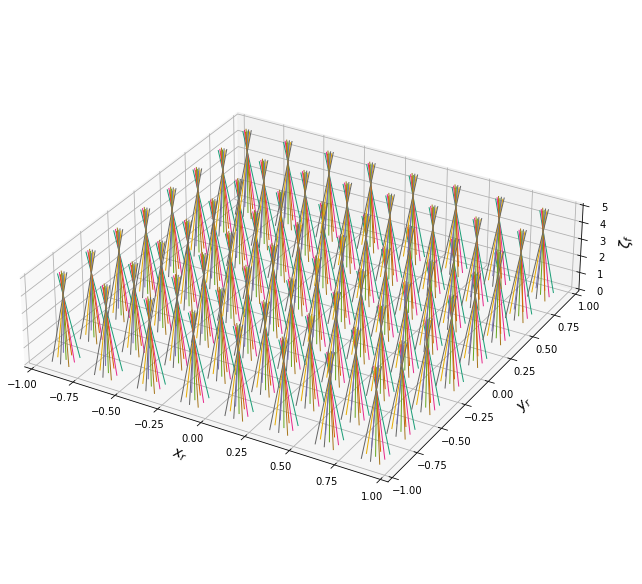

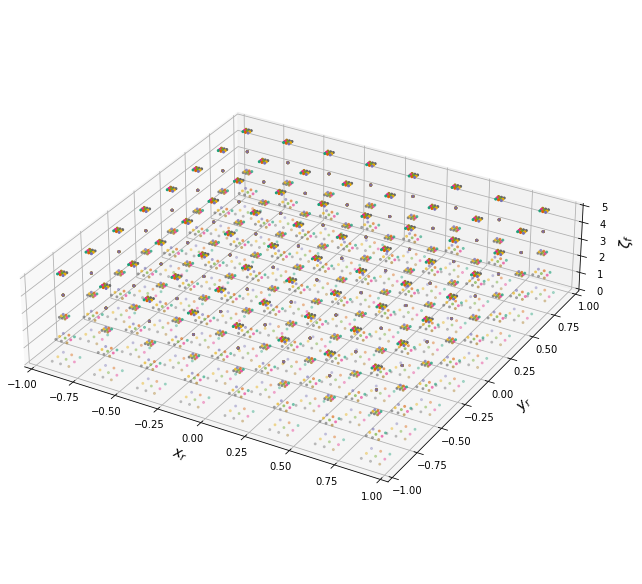

In [15]:
zeta_f = np.linspace(0.00001, 5.0, num=5)
sample_coord_r = intersect_retina(lattice_u.reshape(n_u, 1, 1, 1), lattice_v.reshape(1, n_chunk, chunk_v, 1), z_u, z_v, z_r, 1000 * np.reciprocal(zeta_f))
cmap = cm.get_cmap('Dark2', n_u**2)

ax = pyplot.figure(constrained_layout=True, figsize=(8, 8)).add_subplot(projection='3d')
ax.set_xlabel('\n' + r'$x_r$', fontsize=14)
ax.set_ylabel('\n' + r'$y_r$', fontsize=14)
ax.set_zlabel(r'$\zeta_f$', fontsize=14)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(0.0, 5.0)
ax.set_box_aspect([4,4,1])

for i_u in range(n_u):
    for j_u in range(n_u):
        for i_v in range(n_v):
            for j_v in range(n_v):
                if sample_incidence_on_pupil[i_u, i_v, 0] and sample_incidence_on_pupil[j_u, j_v, 0]:
                    ax.plot(4*sample_coord_r[i_u, i_v, 0], 4*sample_coord_r[j_u, j_v, 0], zeta_f, linewidth=1, c=cmap(i_u + j_u * n_u))

ax = pyplot.figure(constrained_layout=True, figsize=(8, 8)).add_subplot(projection='3d')
ax.set_xlabel('\n' + r'$x_r$', fontsize=14)
ax.set_ylabel('\n' + r'$y_r$', fontsize=14)
ax.set_zlabel(r'$\zeta_f$', fontsize=14)
ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(0.0, 5.0)
ax.set_box_aspect([4,4,1])

for i_u in range(n_u):
    for j_u in range(n_u):
        for i_v in range(n_v):
            for j_v in range(n_v):
                if sample_incidence_on_pupil[i_u, i_v, 0] and sample_incidence_on_pupil[j_u, j_v, 0]:
                    ax.scatter(4*sample_coord_r[i_u, i_v, 0], 4*sample_coord_r[j_u, j_v, 0], zeta_f, linewidth=1, s=2**2, color=cmap(i_u + j_u * n_u))